# Cleaning and Augmentation
This notebook is meant to read in the data downloaded from reddit and prepare it for analysis by cleaning it and doing some computation...

But is has become my whole analysis - sorry...

## Setup

In [109]:
import pandas as pd
import datetime
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
import collections

In [110]:
# Change this to analyze something else

# ## a big one:
# subreddit = "enlightenedbirdmen"
# download_date_string = "19.12.04-14:27:14"

## a meduim one:
subreddit = "justwriterthings"
download_date_string = "19.12.04-10:30:56"

# ## a small one:
# subreddit = "The_B_Emoji"
# download_date_string = "19.12.04-09:28:30"

# ## a very small one:
# subreddit = "GamesWithHorses"
# download_date_string = "19.12.04-10:33:02"

# subreddit = "relationship_advice"
# download_date_string = "19.12.05-20:17:26"

# subreddit = "Showerthoughts"
# download_date_string = "19.12.05-20:40:00"

# subreddit = "todayilearned"
# download_date_string = "19.12.05-19:38:34"

In [111]:
# Constants
data_directory = "downloads/"
submissions_suffix = "-submissions-" + download_date_string + ".csv"
comments_suffix = "-comments-" + download_date_string + ".csv"

## Read the Data

In [112]:
# Read the submissions
submissions_file = data_directory + subreddit + submissions_suffix
submissions = pd.read_csv(submissions_file, index_col=0)
submissions.head()

,submission_id,user,utc,score,title,body,subreddit
0,e5jhlq,Not_a_Buddhist,1.575390e+09,93,Shouldn't you be revising?,NaN,justwriterthings
1,e5jas3,H_G_Bells,1.575390e+09,39,mfw I read some of my old work,NaN,justwriterthings
2,e58mw6,TheTBird99,1.575334e+09,98,Sometimes it is the only way...,NaN,justwriterthings
3,e4sxrw,Joan_Ninja_Hen,1.575257e+09,1,Author's Journey Tag VLogmas Letter V,NaN,justwriterthings
4,e4o70s,lbastro,1.575236e+09,122,Me after writing 2 sentences of my WIP,NaN,justwriterthings


In [113]:
# Read the comments
comments_file = data_directory + subreddit + comments_suffix
comments = pd.read_csv(comments_file, index_col=0)
comments.head()

,comment_id,submission_id,user,utc,score,body
0,f9lexqt,t3_e5jhlq,Silfurgames,1.575421e+09,3,"It's true, I would rather die"
1,f9mhlad,t3_e5jhlq,Runeha_Sneha,1.575459e+09,2,Stabbing my own eyes out sounds like a better ...
2,f9kqs6u,t3_e5jas3,madmaxandrade,1.575406e+09,3,"Y'know, it's actually a good thing. It shows y..."
3,f9iiybk,t3_e58mw6,elysianism,1.575338e+09,-1,r/boomerhumour
4,f9kfeou,t3_e4o70s,Not_a_Buddhist,1.575399e+09,1,Quality shit-posting


## Data Cleaning

In [114]:
# Remove the t3_ prefix from comment submission ids
comments["submission_id"] = comments["submission_id"].apply(lambda s: s.split("t3_")[1])

# Empty content should be the empty string - not nan
submissions['body'] = submissions['body'].fillna(value="")
comments['body'] = comments['body'].fillna(value="")

## Data Conversion

In [115]:
# Convert utc to date
submissions['date'] = submissions['utc'].apply(datetime.datetime.utcfromtimestamp)
comments['date'] = comments['utc'].apply(datetime.datetime.utcfromtimestamp)
#submissions.head()
comments.head()

,comment_id,submission_id,user,utc,score,body,date
0,f9lexqt,e5jhlq,Silfurgames,1.575421e+09,3,"It's true, I would rather die",2019-12-04 01:03:53
1,f9mhlad,e5jhlq,Runeha_Sneha,1.575459e+09,2,Stabbing my own eyes out sounds like a better ...,2019-12-04 11:35:30
2,f9kqs6u,e5jas3,madmaxandrade,1.575406e+09,3,"Y'know, it's actually a good thing. It shows y...",2019-12-03 20:46:30
3,f9iiybk,e58mw6,elysianism,1.575338e+09,-1,r/boomerhumour,2019-12-03 01:57:58
4,f9kfeou,e4o70s,Not_a_Buddhist,1.575399e+09,1,Quality shit-posting,2019-12-03 18:55:07


In [116]:
# Ensure time ordering of submissions
submissions = submissions.sort_values(['date'], ascending = [1]).reset_index()
submissions.head()

,index,submission_id,user,utc,score,title,body,subreddit,date
0,596,7zdxwf,AliceTheGamedev,1.519295e+09,36,Everyone struggles with the same things,,justwriterthings,2018-02-22 10:23:10
1,595,7zdy3a,AliceTheGamedev,1.519295e+09,47,gotta find your motivation somewhere,,justwriterthings,2018-02-22 10:24:24
2,594,7zdy73,AliceTheGamedev,1.519295e+09,38,I remembered that sounding better somehow...,,justwriterthings,2018-02-22 10:25:10
3,593,7zf09y,AliceTheGamedev,1.519307e+09,24,This is definitely how you fix plot holes,,justwriterthings,2018-02-22 13:51:36
4,592,7zf0df,AliceTheGamedev,1.519308e+09,18,Authors are such romantic people...,,justwriterthings,2018-02-22 13:52:10


## Pagerank
This uses [networkx](https://networkx.github.io/documentation/networkx-1.10/index.html)

In [117]:
# # proff that directed edges are defined (start, end)
# d = nx.DiGraph()
# d.add_node(1)
# d.add_node(2)
# d.add_edge(1, 2)
# nx.draw_networkx(d)

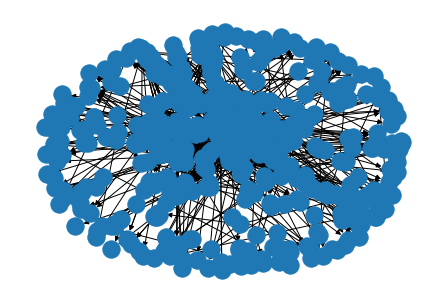

In [118]:
# Start by creating a directed graph
g = nx.DiGraph()

# Each user is a node in the graph
g.add_nodes_from(set(submissions['user'].append(comments['user'])))

# Each comment is a directed edge
pd.merge(submissions, comments, on='submission_id') \
    .apply(lambda row: g.add_edge(row["user_y"], row["user_x"]), axis=1)

# Visualize the graph
nx.draw(g)
plt.show()

In [119]:
# Now lets calculate pagerank
pagerank = nx.pagerank(g)
#pagerank # uncomment to preview

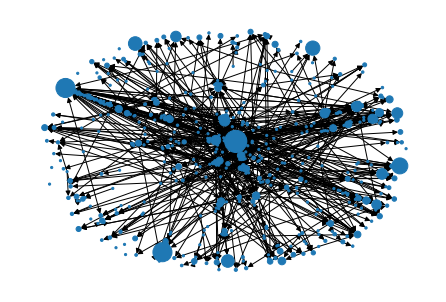

In [120]:
# and visualize it - 8000 is just a scaling factor to make the dots visible
nx.draw(g, node_size=[8000 * x for x in pagerank.values()])
plt.show()

## KLD

In [121]:
# Start by defining post content
submissions['content'] = submissions['body'] + submissions['title']

In [122]:
# A helper for calculating word frequencies
def p_dist(content):
    words = content.split() # tokenize by splitting on whitespace
    counts = collections.Counter(words)
    total = sum(counts.values())
    return {word: count / total for word, count in counts.items()}

# Calculate the word frequencies for every submission
submissions['word_p_dist'] = submissions['content'].apply(p_dist)

In [123]:
# And now calculating entropy is easy
submissions['entropy'] = submissions['word_p_dist'].apply(lambda d: scipy.stats.entropy(list(d.values()), base=2))

In [124]:
# A constant because 0 probabilities break math
infinitesimal = 0.0001

# Helper for calculating kld
def kld(word_freq1, word_freq2):
    if word_freq1 == None or word_freq2 == None:
        return np.nan
    p_dist1 = []
    p_dist2 = []
    for (word, freq) in word_freq1.items():
        p_dist1.append(freq)
        p_dist2.append(infinitesimal if not word in word_freq2 else word_freq2[word])
    for (word, freq) in word_freq2.items():
        if not word in word_freq1:
            p_dist1.append(infinitesimal)
            p_dist2.append(freq)
    return scipy.stats.entropy(p_dist1, p_dist2, base=2)

## simple test - should be equal
# scipy.stats.entropy([0.25, 0.75, infinitesimal], [0.5, 0.4, 0.1], base=2)
# kld({'a':0.25, 'b':0.75}, {'a':0.5, 'b':0.4, 'c':0.1})

In [125]:
# Calculate novelty
submissions['prev_submission_dist'] = submissions['word_p_dist'].shift(1).replace(to_replace={float("Nan"): None})
submissions['novelty'] = submissions.apply(lambda row: kld(row['word_p_dist'], row['prev_submission_dist']), axis=1)
submissions = submissions.drop('prev_submission_dist', axis=1)

In [126]:
# And calculate transience
submissions['next_submission_dist'] = submissions['word_p_dist'].shift(-1).replace(to_replace={float("Nan"): None})
submissions['transience'] = submissions.apply(lambda row: kld(row['word_p_dist'], row['next_submission_dist']), axis=1)
submissions = submissions.drop('next_submission_dist', axis=1)

In [127]:
# Calculate novelty based on multiple previous submissions
window_size = 5

# Helper to average kld of multiple other submissions
def average_kld(of_dist, given_dists):
    if any(map(lambda x: x == None, given_dists)):
        return float("Nan")
    return np.mean(list(map(lambda given_dist: kld(of_dist, given_dist), given_dists)))

# Get the distributions of earlier submissions
submissions['prev_dists'] = submissions['word_p_dist'].apply(lambda x: list()) # get a sequence of empty lists
for i in range(1, window_size + 1):
    submissions['prev_dists'] = submissions['prev_dists'].combine(submissions['word_p_dist'].shift(i).replace(to_replace={float("Nan"): None}), lambda x, y: x + [y])

# And calculate novelty based on that window
submissions['novelty_5'] = submissions.apply(lambda row: average_kld(row['word_p_dist'], row['prev_dists']), axis=1)

# Cleanup
submissions = submissions.drop('prev_dists', axis=1)

In [128]:
# Get the distributions of later submissions
submissions['next_dists'] = submissions['word_p_dist'].apply(lambda x: list()) # get a sequence of empty lists
for i in range(1, window_size + 1):
    submissions['next_dists'] = submissions['next_dists'].combine(submissions['word_p_dist'].shift(-1 * i).replace(to_replace={float("Nan"): None}), lambda x, y: x + [y])

# And calculate novelty based on that window
submissions['transience_5'] = submissions.apply(lambda row: average_kld(row['word_p_dist'], row['next_dists']), axis=1)

# Cleanup
submissions = submissions.drop('next_dists', axis=1)

In [129]:
# Add a column for the difference between novelty and transience - let's call this... the impact
submissions['impact'] = submissions['novelty'] - submissions['transience']
submissions['impact_5'] = submissions['novelty_5'] - submissions['transience_5']

## Grouping By Users

In [130]:
user_submissions = submissions.groupby("user").apply(lambda g: pd.Series(
    {
        'num_posts': g['title'].size,
        'max_score': g['score'].max(),
        'mean_score': g['score'].mean(),
        'min_score': g['score'].min(),
        'mean_length': g.apply(lambda row: len(row['title'] + row['body']), axis=1).mean(),
        'pagerank': pagerank[g['user'].iloc[0]], # weird indexing gets username and then finds pagerank for that user
        'mean_impact': g['impact'].mean(),
        'mean_novelty': g['novelty'].mean(),
        'mean_transience': g['transience'].mean(),
        'mean_impact_5': g['impact_5'].mean(),
        'mean_novelty_5': g['novelty_5'].mean(),
        'mean_transience_5': g['transience_5'].mean()
    }
))
user_submissions.head()

,num_posts,max_score,mean_score,min_score,mean_length,pagerank,mean_impact,mean_novelty,mean_transience,mean_impact_5,mean_novelty_5,mean_transience_5
user,,,,,,,,,,,,
--__uwu__--,1.0,36.0,36.0,36.0,356.0,0.003847,0.159479,7.831459,7.671980,-0.312901,7.156295,7.469196
19Codamadaco98,1.0,54.0,54.0,54.0,29.0,0.001644,0.023162,10.957031,10.933869,0.010165,10.956246,10.946081
8Albion8,1.0,120.0,120.0,120.0,15.0,0.000939,0.004597,11.695730,11.691133,-0.006491,11.686051,11.692542
8BitsAndAByte,1.0,4.0,4.0,4.0,71.0,0.000596,0.011845,9.578154,9.566310,0.345986,9.280350,8.934364
Ahlyae,2.0,101.0,86.5,72.0,61.0,0.006268,0.850253,10.086584,9.236332,0.756347,9.984659,9.228312


In [131]:
user_comments = comments.groupby("user").apply(lambda g: pd.Series(
    {
        'num_comments': g['body'].size,
        'max_score': g['score'].max(),
        'mean_score': g['score'].mean(),
        'min_score': g['score'].min(),
        'mean_length': g['body'].apply(len).mean(),
        'pagerank': pagerank[g['user'].iloc[0]] # weird indexing gets username and then finds pagerank for that user
    }
))
user_comments.head()

,num_comments,max_score,mean_score,min_score,mean_length,pagerank
user,,,,,,
-Rapier,1.0,14.0,14.0,14.0,200.0,0.000596
17x17x17RubixCube,1.0,4.0,4.0,4.0,67.0,0.000596
762Rifleman,1.0,3.0,3.0,3.0,480.0,0.000596
AFP312,1.0,7.0,7.0,7.0,23.0,0.000596
ActualFaithlessness0,5.0,5.0,2.4,1.0,231.6,0.000596


## Merging the Tables

In [132]:
users = user_submissions.join(user_comments, how="outer", lsuffix="_submissions", rsuffix="_comments")

## Clean up after the merge

# outer join means pagerank may only be defined in one case and not the other - combine them
users['pagerank'] = users.apply(lambda row: row['pagerank_comments'] if np.isnan(row['pagerank_submissions']) else row['pagerank_submissions'], axis=1)
users = users.drop('pagerank_submissions', axis=1)
users = users.drop('pagerank_comments', axis=1)
users.head()

,num_posts,max_score_submissions,mean_score_submissions,min_score_submissions,mean_length_submissions,mean_impact,mean_novelty,mean_transience,mean_impact_5,mean_novelty_5,mean_transience_5,num_comments,max_score_comments,mean_score_comments,min_score_comments,mean_length_comments,pagerank
user,,,,,,,,,,,,,,,,,
--__uwu__--,1.0,36.0,36.0,36.0,356.0,0.159479,7.831459,7.671980,-0.312901,7.156295,7.469196,NaN,NaN,NaN,NaN,NaN,0.003847
-Rapier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,14.0,14.0,14.0,200.0,0.000596
17x17x17RubixCube,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,4.0,4.0,67.0,0.000596
19Codamadaco98,1.0,54.0,54.0,54.0,29.0,0.023162,10.957031,10.933869,0.010165,10.956246,10.946081,NaN,NaN,NaN,NaN,NaN,0.001644
762Rifleman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,3.0,3.0,480.0,0.000596


## Save the Data

In [133]:
save_path = "data/"
users.to_csv(save_path + subreddit + "-users-" + download_date_string + ".csv")
submissions.to_csv(save_path + subreddit + "-augmented-submissions-" + download_date_string + ".csv")
comments.to_csv(save_path + subreddit + "-augmented-comments-" + download_date_string + ".csv")

## EDA

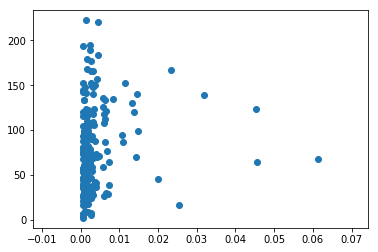

In [134]:
# mean score vs pagerank
plt.scatter(x=users['pagerank'], y=users['mean_score_submissions'])
plt.show()

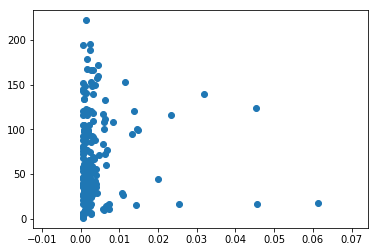

In [135]:
# min score vs pagerank
plt.scatter(x=users['pagerank'], y=users['min_score_submissions'])
plt.show()

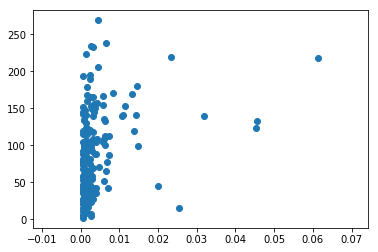

In [136]:
# max score vs pagerank
plt.scatter(x=users['pagerank'], y=users['max_score_submissions'])
plt.show()

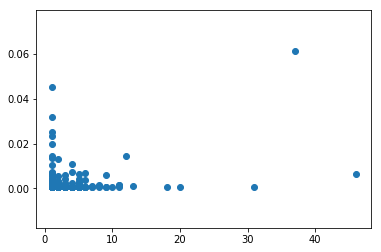

In [137]:
# number of comments vs pagerank
plt.scatter(x=users['num_comments'], y=users['pagerank'])
plt.show()

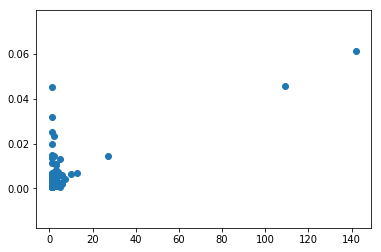

In [138]:
# number of posts vs pagerank - should be correlated (more submissions to comment on)
plt.scatter(x=users['num_posts'], y=users['pagerank'])
plt.show()
# okay, my hypothesis was wrong...

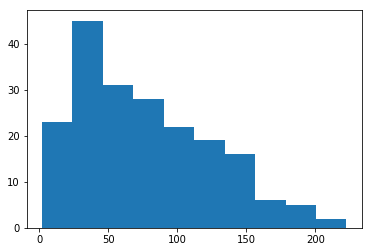

In [139]:
plt.hist(users['mean_score_submissions'])
plt.show()

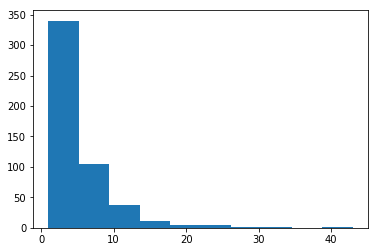

In [140]:
plt.hist(users['mean_score_comments'])
plt.show()

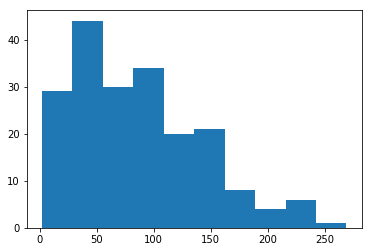

In [141]:
plt.hist(users['max_score_submissions'])
plt.show()

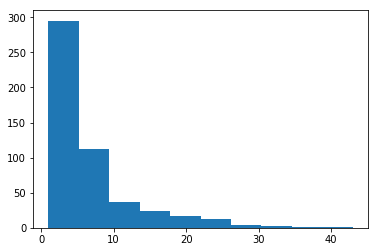

In [142]:
plt.hist(users['max_score_comments'])
plt.show()

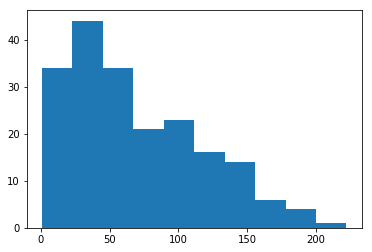

In [143]:
plt.hist(users['min_score_submissions'])
plt.show()

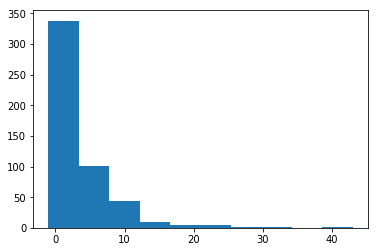

In [144]:
plt.hist(users['min_score_comments'])
plt.show()

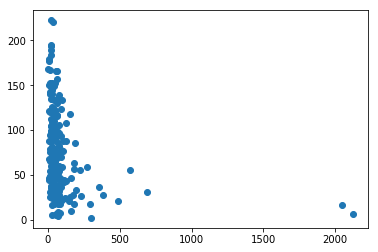

In [145]:
plt.scatter(x=users['mean_length_submissions'], y=users['mean_score_submissions'])
plt.show()

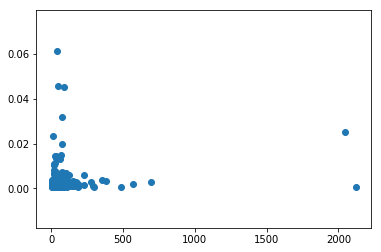

In [146]:
plt.scatter(x=users['mean_length_submissions'], y=users['pagerank'])
plt.show()

## Just Submission Stuff

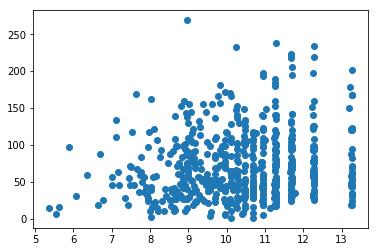

In [147]:
plt.scatter(x=submissions['novelty'], y=submissions['score'])
plt.show()

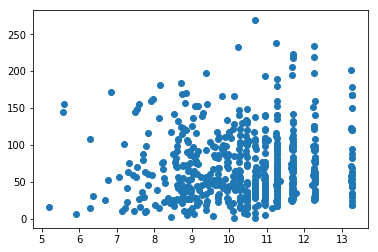

In [148]:
plt.scatter(x=submissions['transience'], y=submissions['score'])
plt.show()

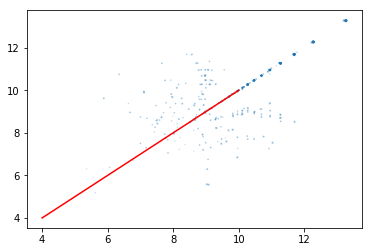

In [149]:
# novelty-transcience plot
plt.scatter(x=submissions['novelty'], y=submissions['transience'], s=submissions['score'] / 100, alpha=0.3)

# add line of equality
domain = np.arange(4, 11)
plt.plot(domain, domain, color='red')
plt.show()

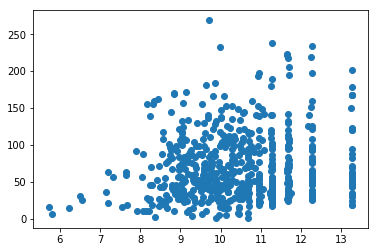

In [150]:
plt.scatter(x=submissions['novelty_5'], y=submissions['score'])
plt.show()

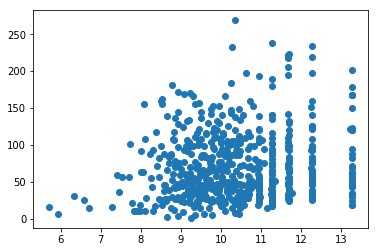

In [151]:
plt.scatter(x=submissions['transience_5'], y=submissions['score'])
plt.show()

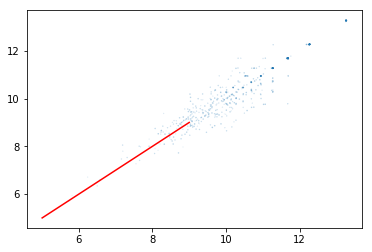

In [152]:
# novelty-transcience plot
plt.scatter(x=submissions['novelty_5'], y=submissions['transience_5'], s=submissions['score'] / 500, alpha=0.3)

# add line of equality
domain = np.arange(5, 10)
plt.plot(domain, domain, color='red')
plt.show()

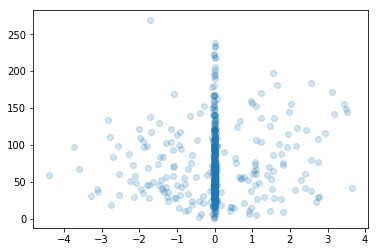

In [153]:
plt.scatter(x=submissions['impact'], y=submissions['score'], alpha=0.2)
plt.show()

## Users and KLD

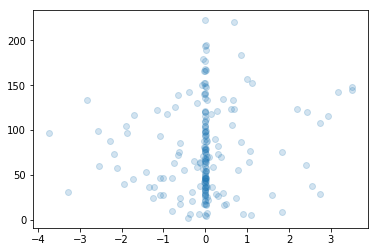

In [154]:
plt.scatter(x=users['mean_impact'], y=users['mean_score_submissions'], alpha=0.2)
plt.show()

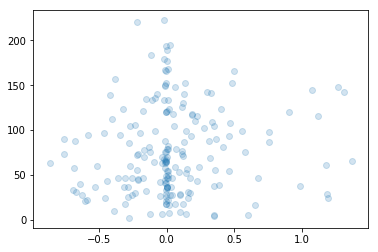

In [155]:
plt.scatter(x=users['mean_impact_5'], y=users['mean_score_submissions'], alpha=0.2)
plt.show()

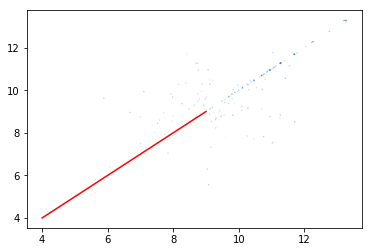

In [156]:
# novelty-transcience plot
plt.scatter(x=users['mean_novelty'], y=users['mean_transience'], s=users['mean_score_submissions'] / 500, alpha=0.3)

# add line of equality
domain = np.arange(4, 10)
plt.plot(domain, domain, color='red')
plt.show()

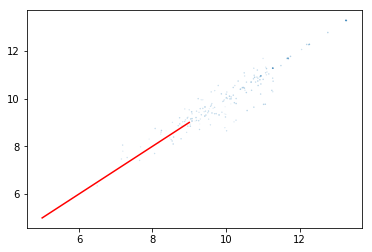

In [157]:
# novelty-transcience plot
plt.scatter(x=users['mean_novelty_5'], y=users['mean_transience_5'], s=users['mean_score_submissions'] / 500, alpha=0.3)

# add line of equality
domain = np.arange(5, 10)
plt.plot(domain, domain, color='red')
plt.show()

## Pagerank and KLD for Users!!!

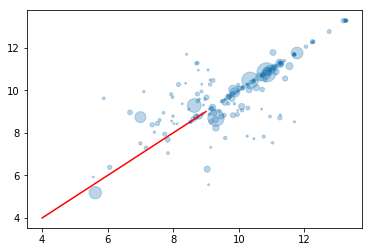

In [158]:
# novelty-transcience plot
plt.scatter(x=users['mean_novelty'], y=users['mean_transience'], s=users['pagerank']*6000, alpha=0.3)

# add line of equality
domain = np.arange(4, 10)
plt.plot(domain, domain, color='red')
plt.show()

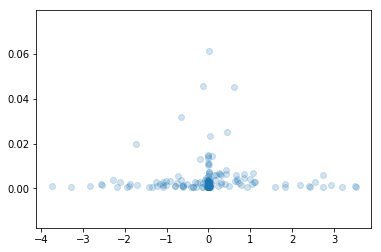

In [159]:
plt.scatter(x=users['mean_impact'], y=users['pagerank'], alpha=0.2)
plt.show()

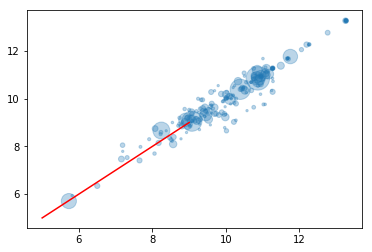

In [160]:
# novelty-transcience plot
plt.scatter(x=users['mean_novelty_5'], y=users['mean_transience_5'], s=users['pagerank']*9000, alpha=0.3)

# add line of equality
domain = np.arange(5, 10)
plt.plot(domain, domain, color='red')
plt.show()

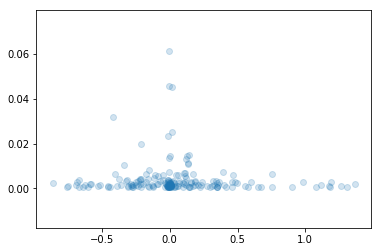

In [161]:
plt.scatter(x=users['mean_impact_5'], y=users['pagerank'], alpha=0.2)
plt.show()

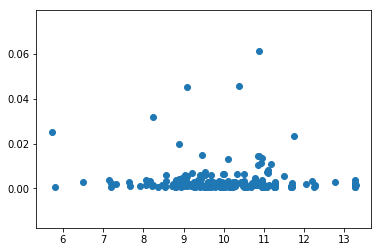

In [162]:
plt.scatter(x=users['mean_novelty_5'], y=users['pagerank'])
plt.show()